In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from datetime import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install ccxt
import ccxt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
 #       print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     |████████████████████████████████| 2.0 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 291 kB 58.9 MB/s eta 0:00:01


In [2]:
print(ccxt.exchanges)
exch = ccxt.aax() # Loads AAX
exch.load_markets()
print ('AAX: %d markets loaded!' % len (exch.markets))
#matplotlib settings
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use ('seaborn-white')
plt.rcParams["figure.figsize"] = [15,6]
pair ="ETH/USDT"
ohlcv = exch.fetch_ohlcv (pair, '1d')
#from random import sample
#sample(ohlcv,20)
ethdf = pd.DataFrame(ohlcv, columns =['Date', 'Open','High','Low','Close','Volume']) 
print(ethdf.index)
print(ethdf.columns)

['aax', 'aofex', 'ascendex', 'bequant', 'bibox', 'bigone', 'binance', 'binancecoinm', 'binanceus', 'binanceusdm', 'bit2c', 'bitbank', 'bitbay', 'bitbns', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitmart', 'bitmex', 'bitpanda', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bitz', 'bl3p', 'btcalpha', 'btcbox', 'btcmarkets', 'btctradeua', 'btcturk', 'buda', 'bw', 'bybit', 'bytetrade', 'cdax', 'cex', 'coinbase', 'coinbaseprime', 'coinbasepro', 'coincheck', 'coinegg', 'coinex', 'coinfalcon', 'coinfloor', 'coinmarketcap', 'coinmate', 'coinone', 'coinspot', 'crex24', 'currencycom', 'delta', 'deribit', 'digifinex', 'eqonex', 'equos', 'exmo', 'exx', 'flowbtc', 'ftx', 'gateio', 'gemini', 'hitbtc', 'hollaex', 'huobi', 'huobijp', 'huobipro', 'idex', 'independentreserve', 'indodax', 'itbit', 'kraken', 'kucoin', 'kuna', 'latoken', 'lbank', 'liquid', 'luno', 'lykke', 'mercado', 'mixcoins', 'ndax', 'novadax', 'oceanex', 'okcoin', 'okex', 'okex3', 

<AxesSubplot:>

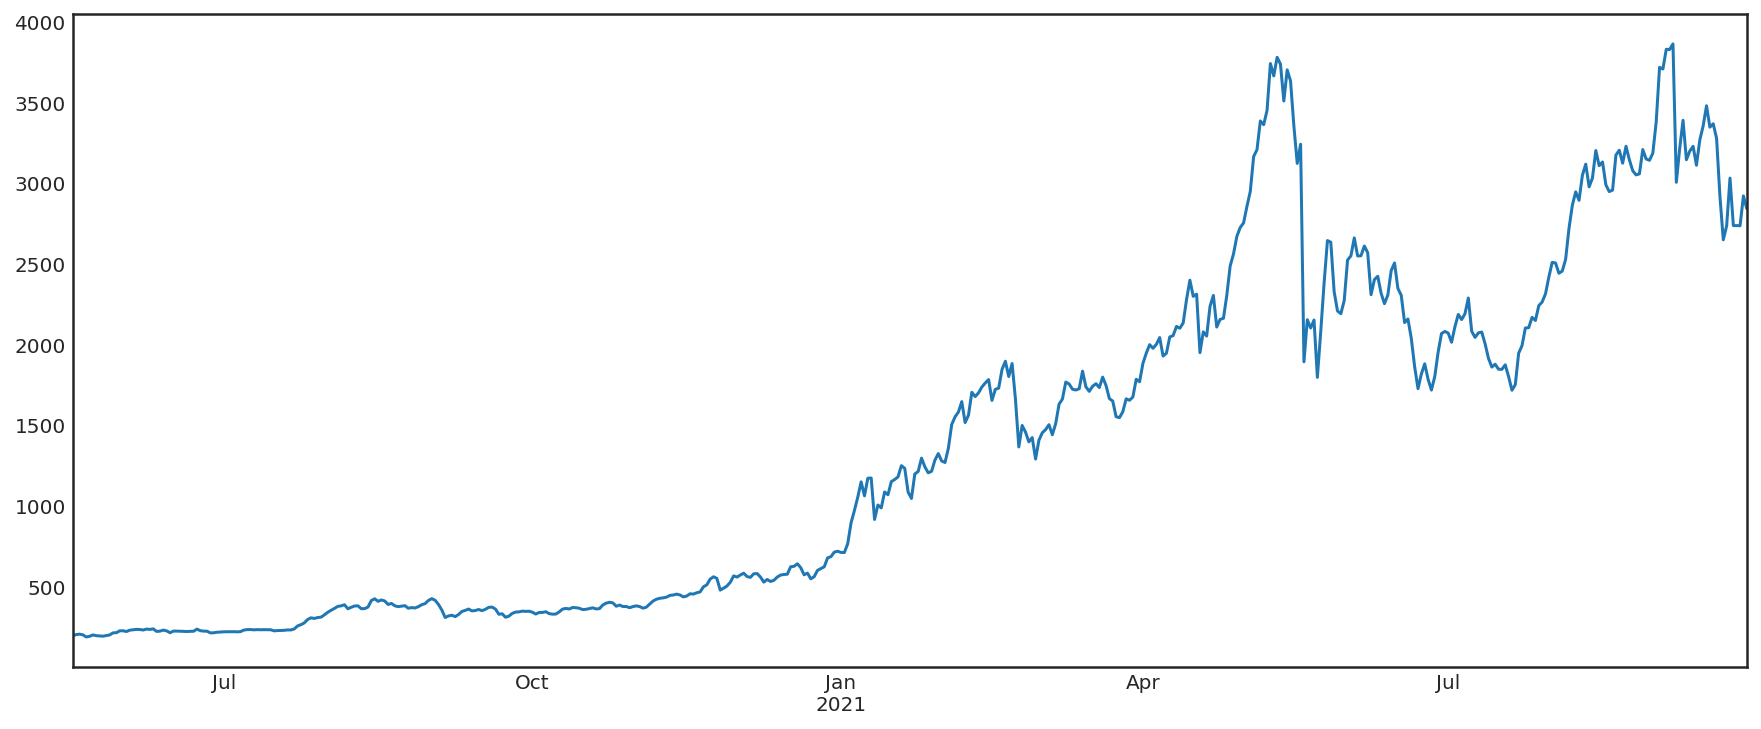

In [3]:
from datetime import datetime
#Using close prices for each day
prices = [x[3] for x in ohlcv]

# Convert Unix timestamps to Python dates
dates = [datetime.fromtimestamp (x[0] // 1000) for x in ohlcv]
ethdf['Date'] = dates
ethdf.index = dates
# Prepare a Pandas series object
data = pd.Series (prices, index=dates) 
# Draw a simple line chart
data.plot ()
#implement manual trading strategy

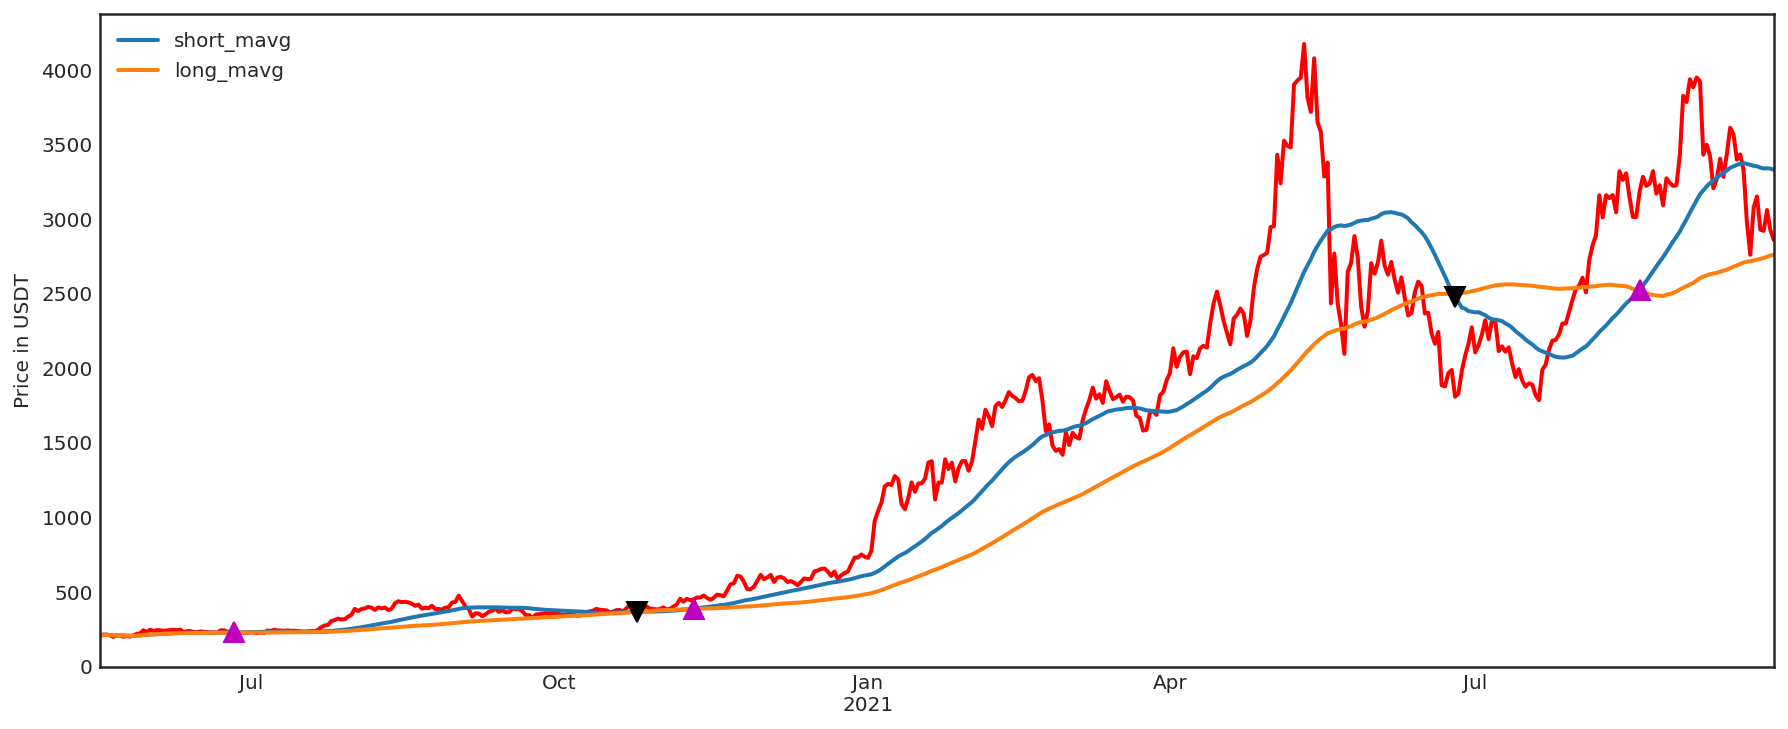

In [4]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=ethdf.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = ethdf['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = ethdf['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in USDT')

# Plot the closing price
ethdf['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [7]:
#Initial portfolio balance
capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['ETH'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ethdf['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ethdf['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = capital - (pos_diff.multiply(ethdf['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

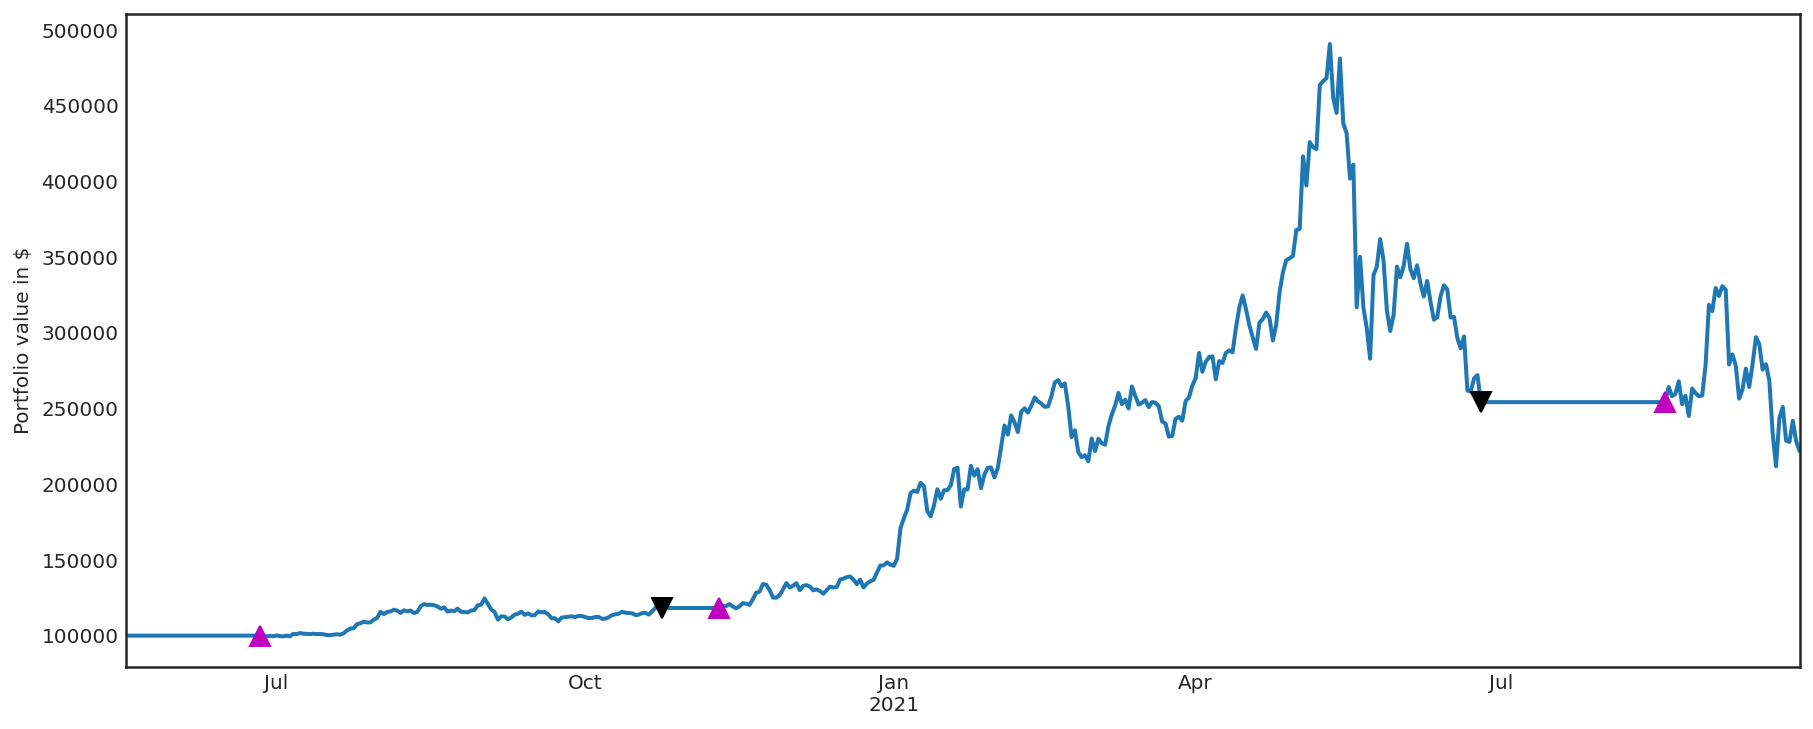

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [9]:
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

1.0011136209997897
